**Data mining Project - University of Pisa, acedemic year 2023/24**
 
**Authors**: Giacomo Aru, Giulia Ghisolfi, Luca Marini, Irene Testa

# Self organizing maps

From the [Pyclustering](https://github.com/annoviko/pyclustering/) library we already used the X-means algorithm, comparing it with K-means. In this notebook we will experiment with Self Organizing Maps (SOM). SOM is an unsupervised neural network model that could be used both for dimensionality reduction, visualization of high-dimensional data and clustering. This model organizes the input data into a lower-dimensional (typically 2 dimensional) grid of neurons (numerical vectors of 'weights'), where each neuron represents a cluster prototype. Neurons weights are randomly initialized and, during training, the network adjusts its weights to map similar input patterns to neighboring locations on the grid, preserving the topological relationships of the input data.

First, we import the libraries:

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from pyclustering.nnet.som import som_parameters, som, type_conn
from clustering_utils import *

We load the data and prepare it for the clustering. We will use the same dataset used with K-means and X-means and we will apply MinMax scaling to normalize the data.

In [2]:
# load the data
incidents_df = pd.read_csv('../data/incidents_indicators.csv', index_col=0)
# load the names of the features to use for clustering
features_to_cluster = json.loads(open('../data/indicators_names.json').read())
# for the clustering we will use all the extracted indicators except the projected coordinates
features_to_cluster = [feature for feature in features_to_cluster if feature not in ['lat_proj', 'lon_proj']]
# drop nan
incidents_df = incidents_df.dropna(subset=features_to_cluster).reset_index(drop=True)
# initialize a colum for the clustering labels
incidents_df['cluster'] = None
# project on the indicators
indicators_df = incidents_df[features_to_cluster]
# apply MinMaxScaler
minmax_scaler = MinMaxScaler()
X = minmax_scaler.fit_transform(indicators_df.values)

The [Pyclustering](https://github.com/annoviko/pyclustering/) library provides a SOM implementation tailored for clustering tasks. However, it lacks specific methods for visualizing the results on the grid. Therefore, we opt for the more generic SOM implementation.

Determining the best configuration of parameters is out of the scope of this notebook. We will use the default parameters of the SOM algorithm, that are:
- adaptation_threshold=0.001, used if autostop=True, determines the threshold for stopping the training
- init_learn_rate=0.1
- init_radius=2 if cols+rows>4
- init_type='distributed in line with uniform grid'

We use a 3x3 grid (i.e. 9 clusters) in which each grid cell has at most 4 neighbors.

In [4]:
som_params = som_parameters()
rows = 3
cols = 3
n_clusters = rows*cols
structure = type_conn.grid_four
network = som(rows, cols, structure, som_params)

We train the model using the autostop criterion:

In [5]:
network.train(X, autostop=True, epochs=100000)

2

We store the clustering results:

In [6]:
for i in range(n_clusters):
    incidents_df.loc[network.capture_objects[i], 'cluster'] = i
prototypes = np.array(network.weights)
clusters = np.array(incidents_df['cluster'].astype(int))

## Characterizations of the clusters

We visualize the size of each cluster on the grid:

Text(0.5, 1.0, 'Number of point per cluster')

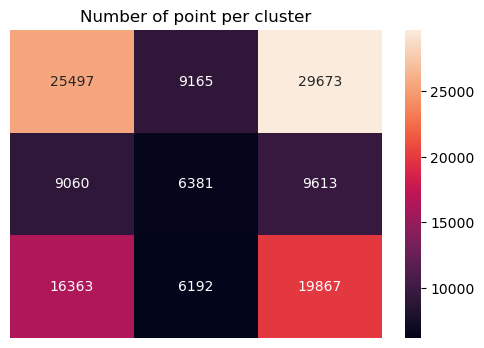

In [7]:
fig, axs = plt.subplots(1, figsize=(6,4))
award_mtx = np.array(network._award).reshape(network._rows, network._cols)
sns.heatmap(award_mtx, annot=True, ax=axs, fmt='.0f')
axs.set_xticks([])
axs.set_yticks([])
plt.title("Number of point per cluster")

This operation was also implemented in the library, but we notice that the colors associated to the grid cells are not in line with the labels. The implementation of the library is probably missing a transposition of the labels.

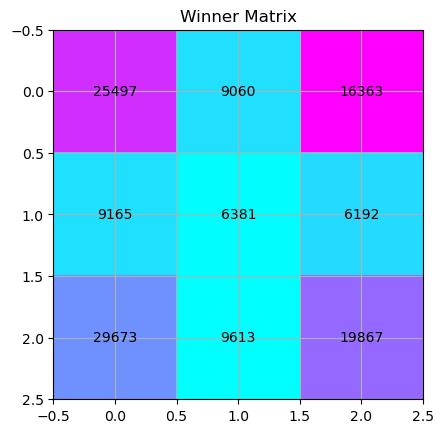

In [8]:
network.show_winner_matrix()

We also visualize the cluster sizes as a bar plot:

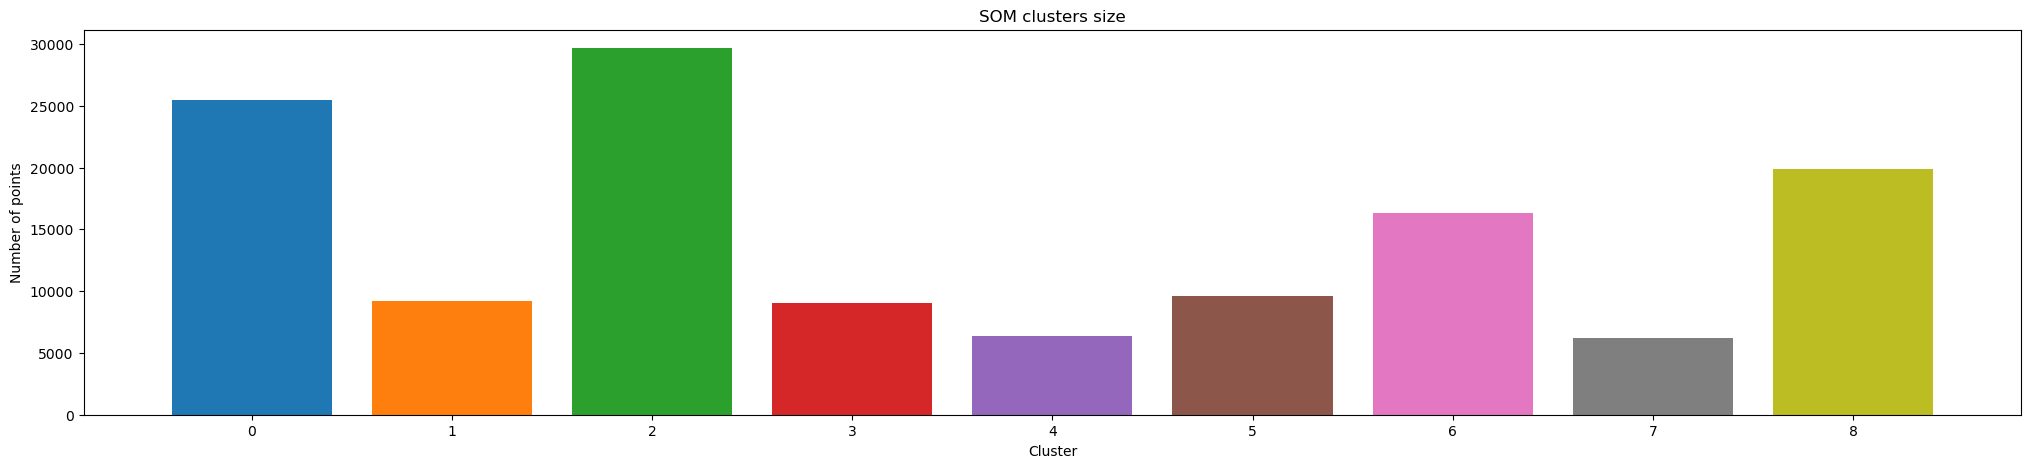

In [9]:
fig, axs = plt.subplots(1, figsize=(25,5))
plot_clusters_size(
    clusters=incidents_df['cluster'],
    ax=axs,
    title='SOM clusters size',
    color_palette=sns.color_palette('tab10')
)

There are two big clusters, 2 clusters with medium size and 5 smaller clusters. Cluster labels are assigned in the order of the grid cells, from left to right and from top to bottom.

To explore the clustering result and the topology of the grid, we will color each cell according to the mean or mode - depending on the type of the variable - of the features of the corresponding cluster. The following function computes the mean or the mode of the given feature for the incidents in the same cluster:

In [10]:
def agg_feature_by_cluster(network, df, feature, agg_fun):
    agg_feature_per_cluster = []
    for i in range(n_clusters):
        agg_feature = df.iloc[network.capture_objects[i]][feature].agg(agg_fun)
        if agg_fun=='mode':
            agg_feature = agg_feature.values[0]
        agg_feature_per_cluster.append(agg_feature)
    return agg_feature_per_cluster

First, we explore numerical features:

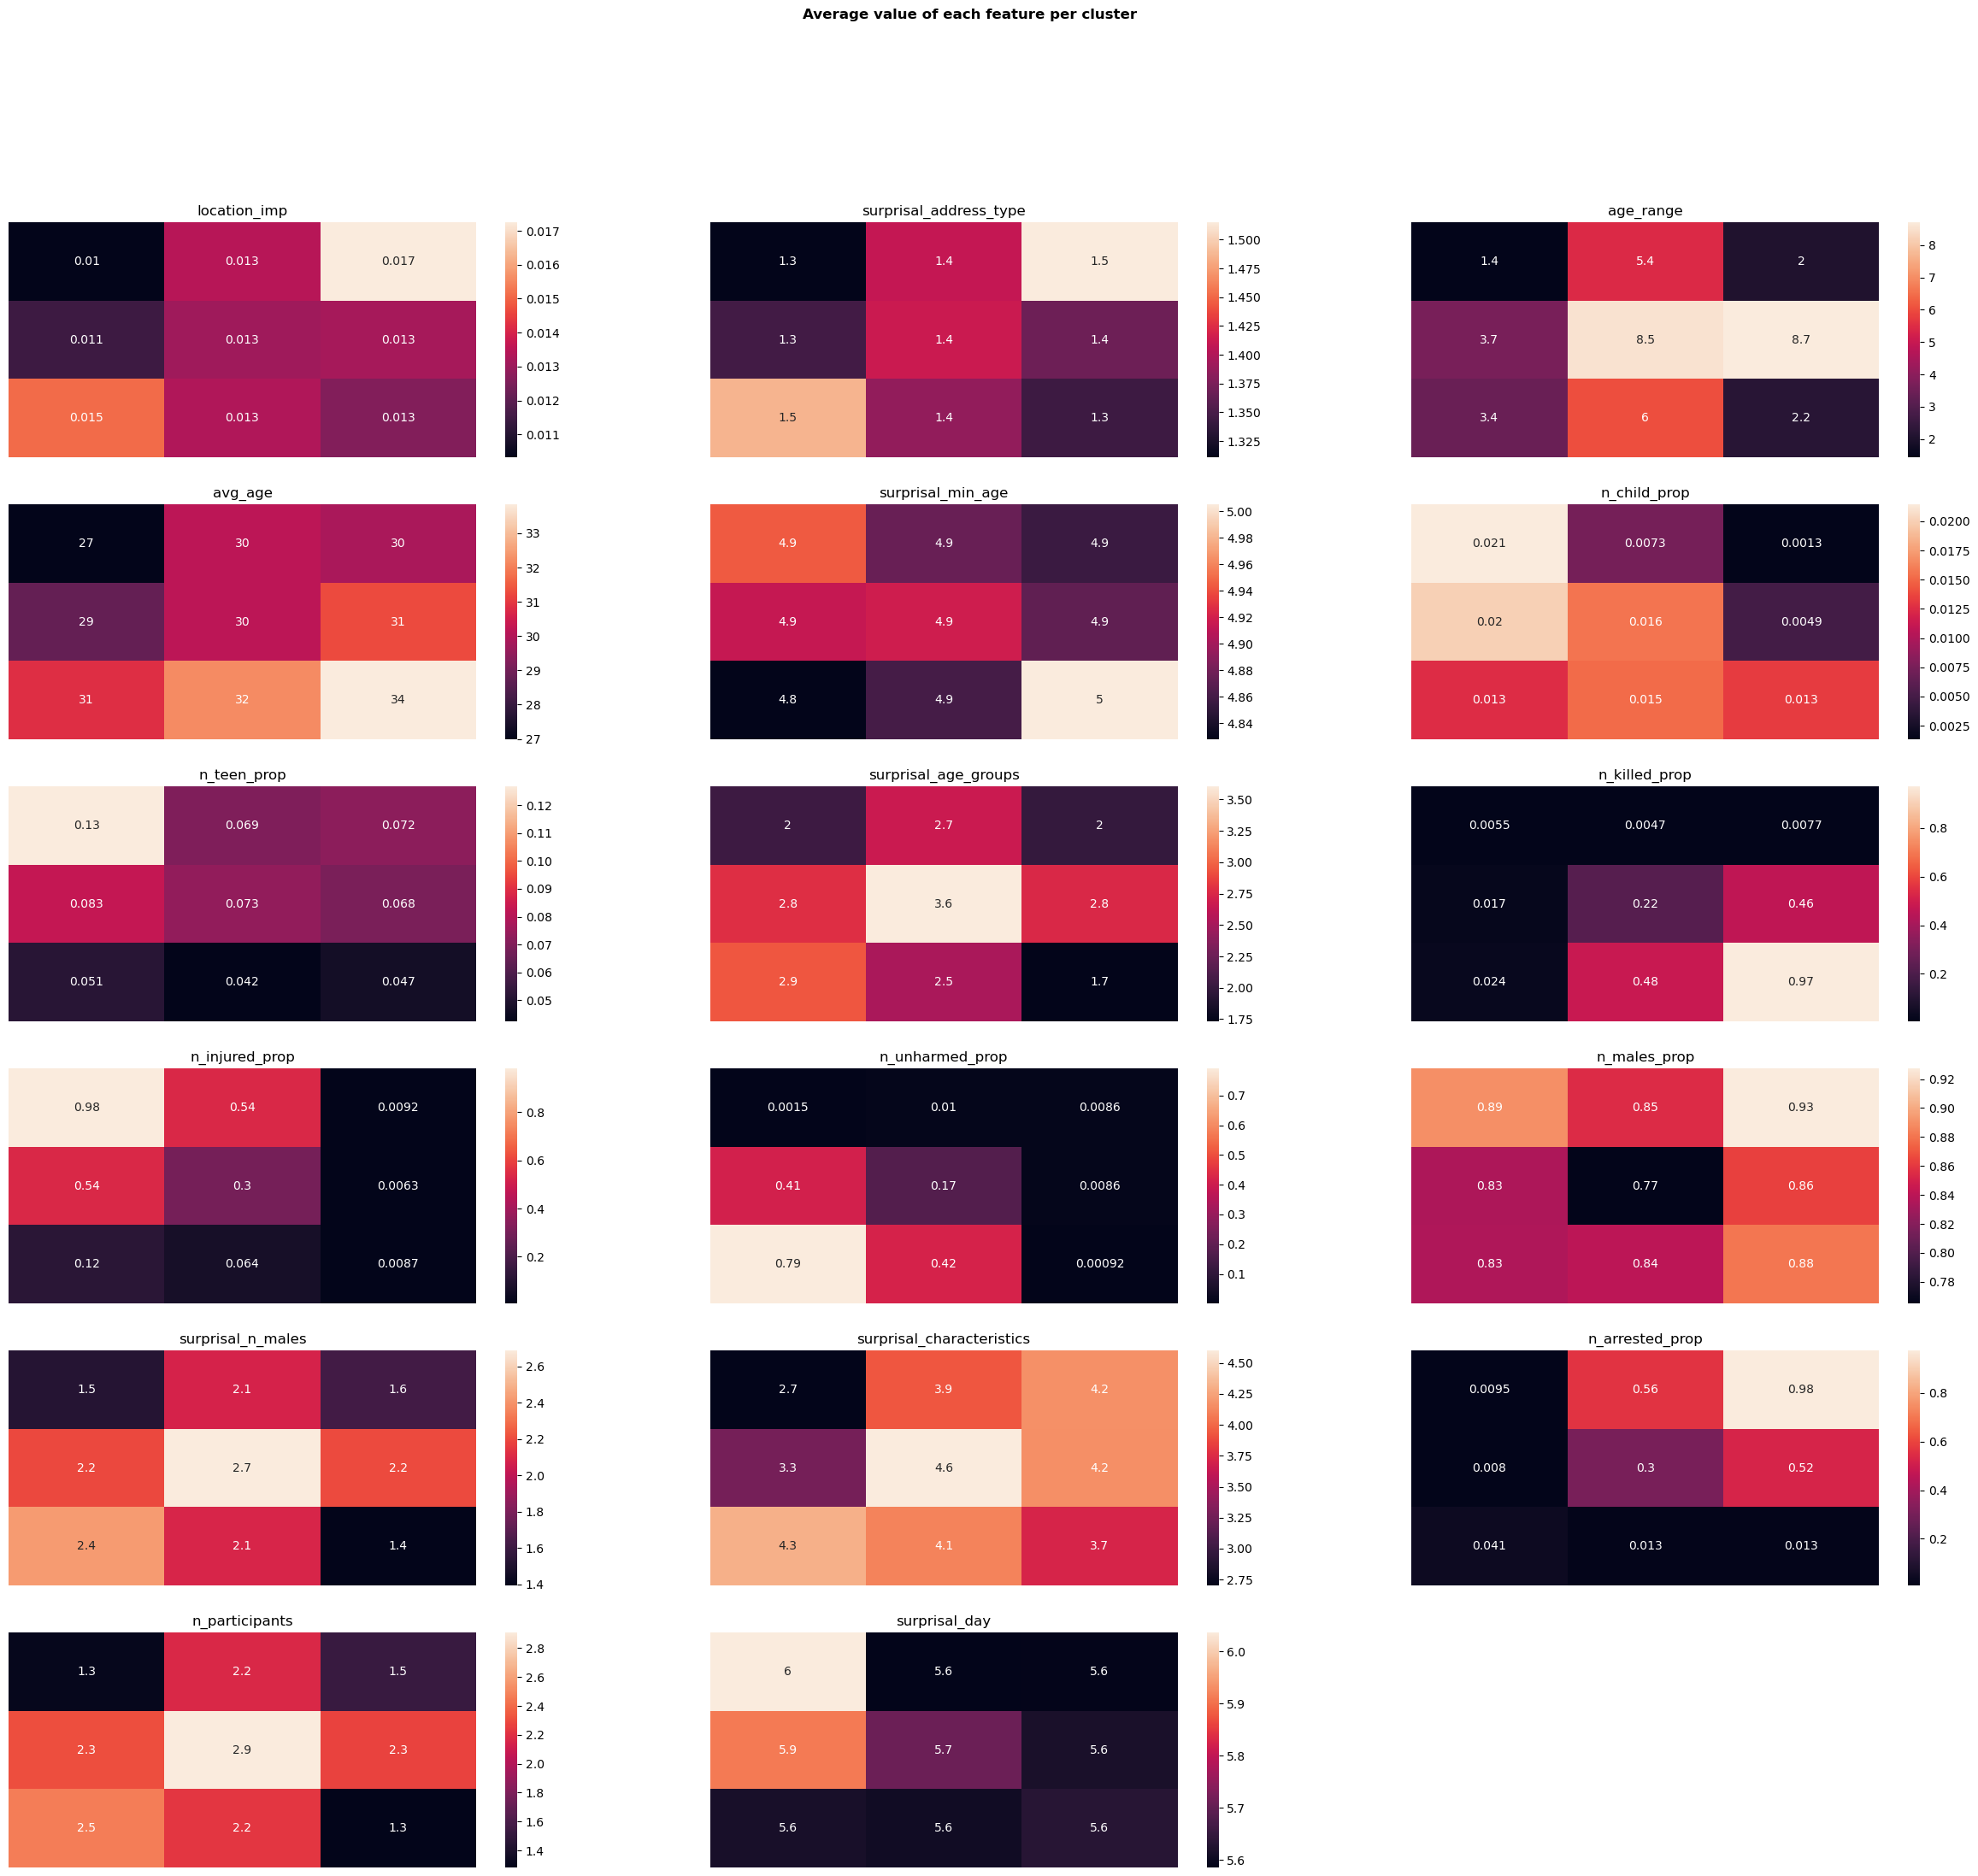

In [11]:
ncols = 3
nplots = len(features_to_cluster)
nrows = int(nplots/ncols)
if nplots % ncols != 0:
    nrows += 1
f, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30,25))
for i, feature in enumerate(features_to_cluster):
    avg_feature_per_cluster = agg_feature_by_cluster(network, indicators_df, feature=feature, agg_fun='mean')
    avg_feature_mtx = np.array(avg_feature_per_cluster).reshape(network._rows, network._cols)
    sns.heatmap(avg_feature_mtx, ax=axs[int(i/ncols)][i%ncols], annot=True)
    axs[int(i/ncols)][i%ncols].set_title(feature)
    axs[int(i/ncols)][i%ncols].set_xticks([])
    axs[int(i/ncols)][i%ncols].set_yticks([])
for ax in axs[nrows-1, i%ncols+1:]:
    ax.remove()
f.suptitle("Average value of each feature per cluster", fontweight='bold');

We notice that:
- the up-left corner of the grid groups incidents with higher values of n_injured_prop
- the up-right corner groups incidents with higher values of n_arrested_prop
- the down-left corner groups incidents with higher values of n_unharmed_prop
- the down-right corner groups incidents with higher values of n_killed_prop
- the center of the grid groups incidents with higher values of suprisal_age_groups, surprisal_n_males, suprisal_characteristics and n_participants; and lower values of n_males_prop

The groups discovered are similar to the ones discovered with K-means (despite the fact that here we are grouping points in 9 clusters).

Now we explore the distribution of categorical features on the grid:

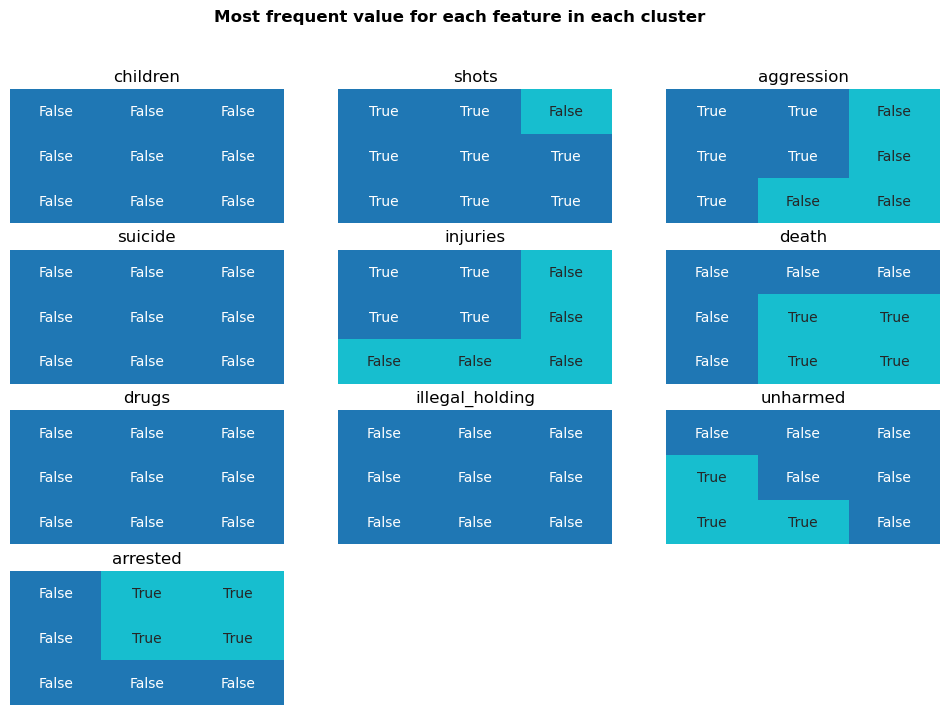

In [12]:
incidents_df['unharmed'] = incidents_df['n_unharmed'] > 0
incidents_df['arrested'] = incidents_df['n_arrested'] > 0
features_to_mode = [
    'children',
    'shots',
    'aggression',
    'suicide',
    'injuries',
    'death',
    'drugs',
    'illegal_holding',
    'unharmed',
    'arrested'
]

nplots = len(features_to_mode)
ncols = 3
nrows = int(nplots / ncols)
if nplots % ncols != 0:
    nrows += 1
f, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,8))
for i, feature in enumerate(features_to_mode):
    mode_per_cluster = agg_feature_by_cluster(network, incidents_df, feature=feature, agg_fun='mode')
    unique_values = incidents_df[feature].unique()
    unique_values_map = {unique_value: i for i, unique_value in enumerate(unique_values)}
    num_mode_per_cluster = [unique_values_map[mode] for mode in mode_per_cluster]
    num_mode_per_cluster_mtx = np.array(num_mode_per_cluster).reshape(network._rows, network._cols)
    mode_per_cluster_mtx = np.array(mode_per_cluster).reshape(network._rows, network._cols)
    sns.heatmap(num_mode_per_cluster_mtx, ax=axs[int(i/ncols)][i%ncols], annot=mode_per_cluster_mtx, cmap='tab10', cbar=False, fmt='')
    axs[int(i/ncols)][i%ncols].set_title(feature)
    axs[int(i/ncols)][i%ncols].set_xticks([])
    axs[int(i/ncols)][i%ncols].set_yticks([])
for ax in axs[nrows-1, i%ncols+1:]:
    ax.remove()
f.suptitle("Most frequent value for each feature in each cluster", fontweight='bold');

The distribution of the variables is in line with the one observations made regarding the numerical features.

We now visualize the U-matrix, where each cell is colored according to the average distance between the weights of the cell and its neighbors:

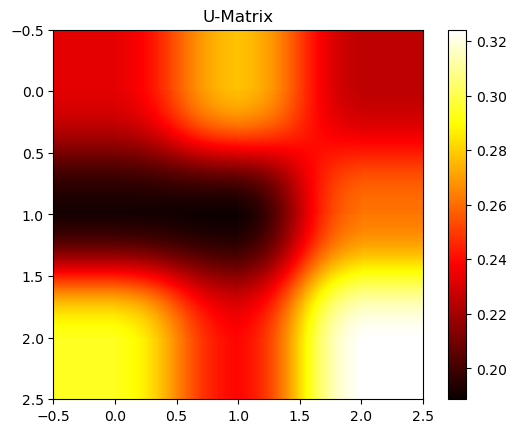

In [13]:
network.show_distance_matrix()

We notice that the prototype of the cell in the middle of the grid is similar to all the adjacent cells (it has not a unique identity). Instead, the prototipe of the cluster in the down-left corner is well separated from the adjacent prototipes.

We visualize clusters in the principal components space:

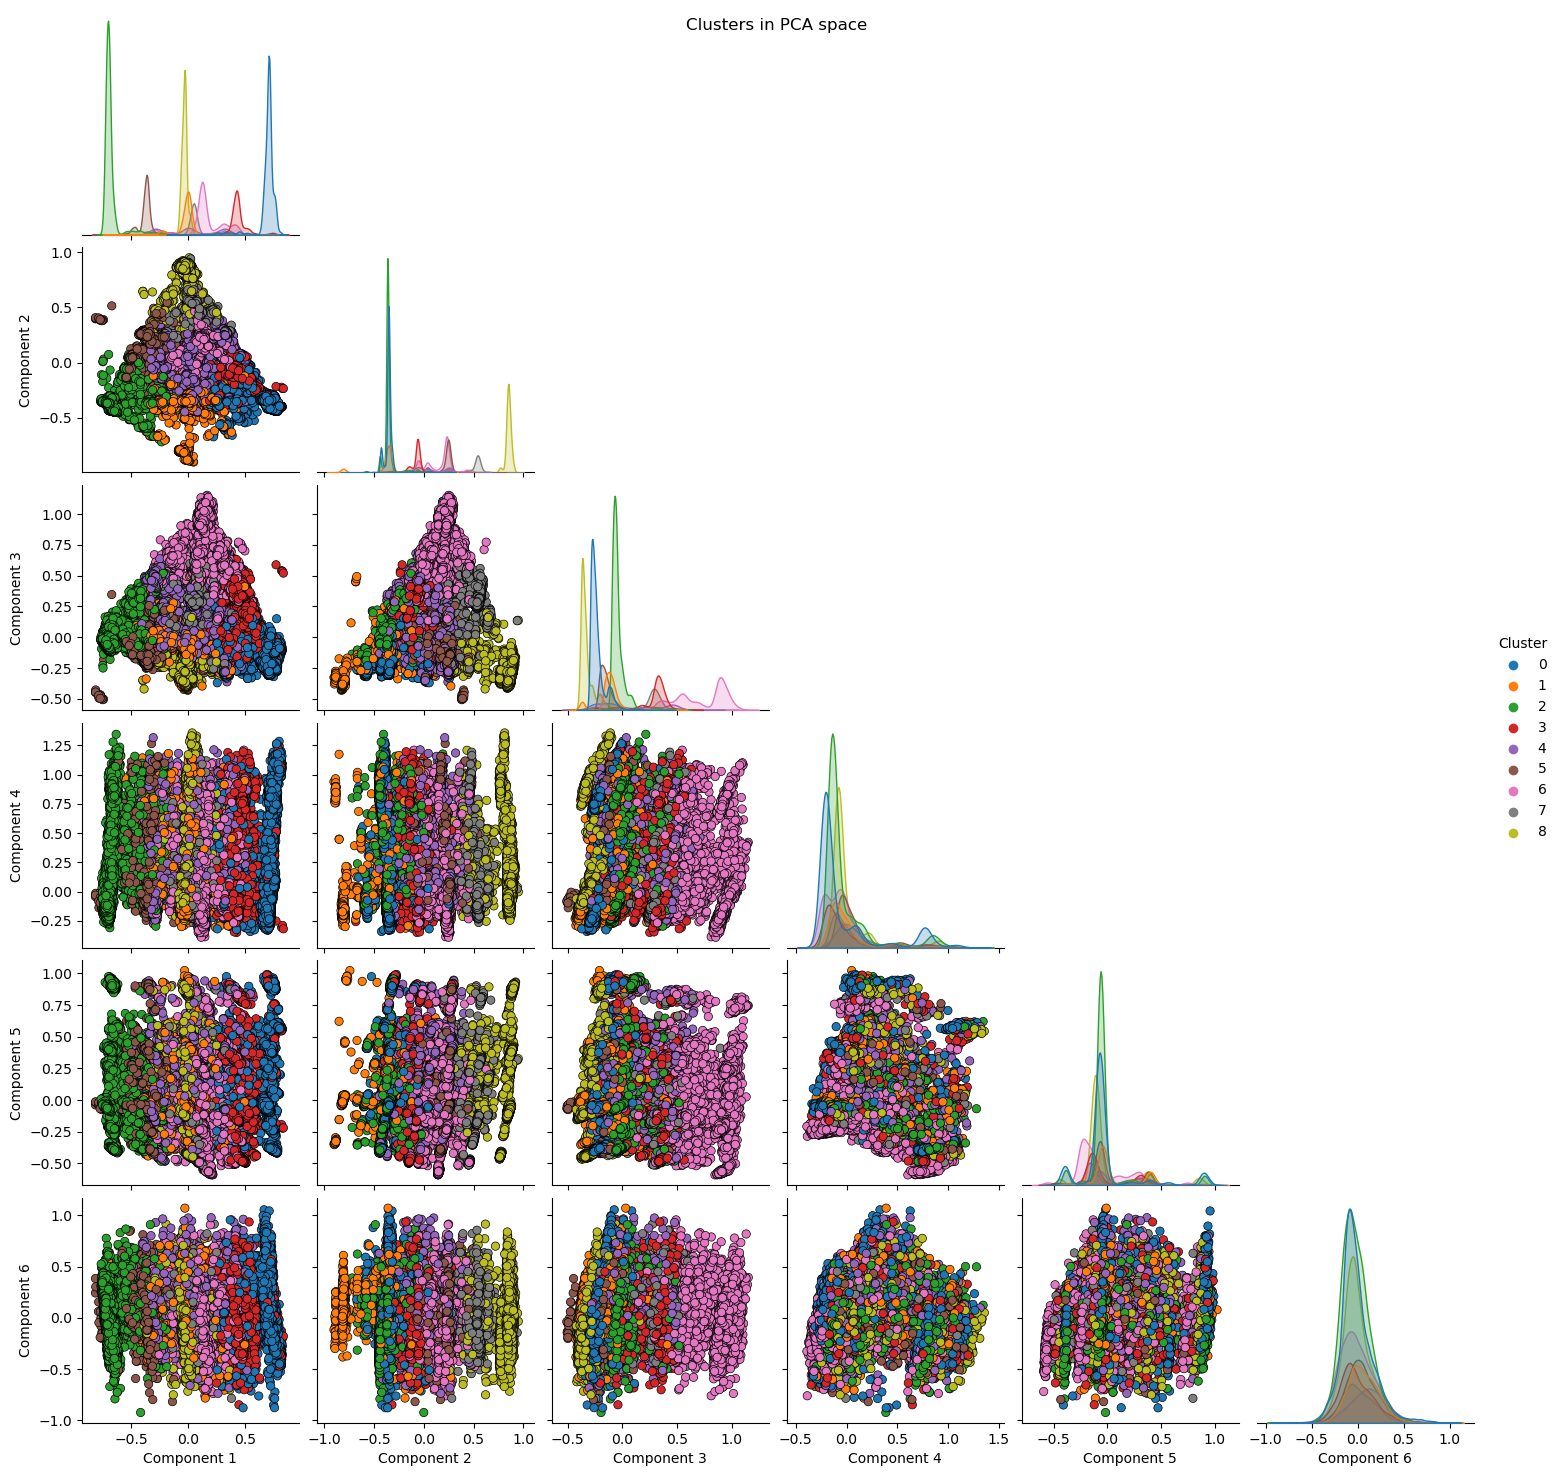

In [14]:
pca = PCA()
X_pca = pca.fit_transform(X)
palette = [sns.color_palette('tab10')[i] for i in range(n_clusters)]
scatter_pca_features_by_cluster(
    X_pca=X_pca,
    n_components=6,
    clusters=incidents_df['cluster'],
    palette=palette,
    hue_order=None,
    title='Clusters in PCA space'
)

Clusters are quite separated in the feature space of the first principal components.

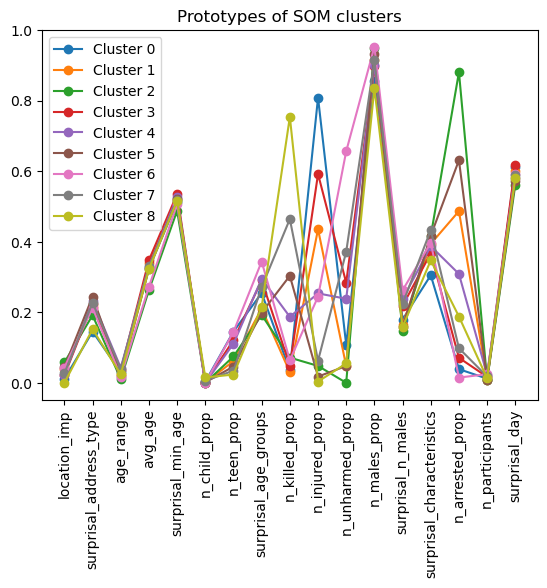

In [15]:
for j in range(0, len(prototypes)):
    plt.plot(prototypes[j], marker='o', label='Cluster %s' % j, c=sns.color_palette('tab10')[j])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(0, len(features_to_cluster)), features_to_cluster, rotation=90)
plt.legend(fontsize=10)
plt.title(f'Prototypes of SOM clusters');

The features that differentiate the most the clusters prototipes are, as expected, the following:
- n_killed_prop
- n_injured_prop
- n_unharmed_prop
- n_arrested_prop

## Distribution of variables in the clusters

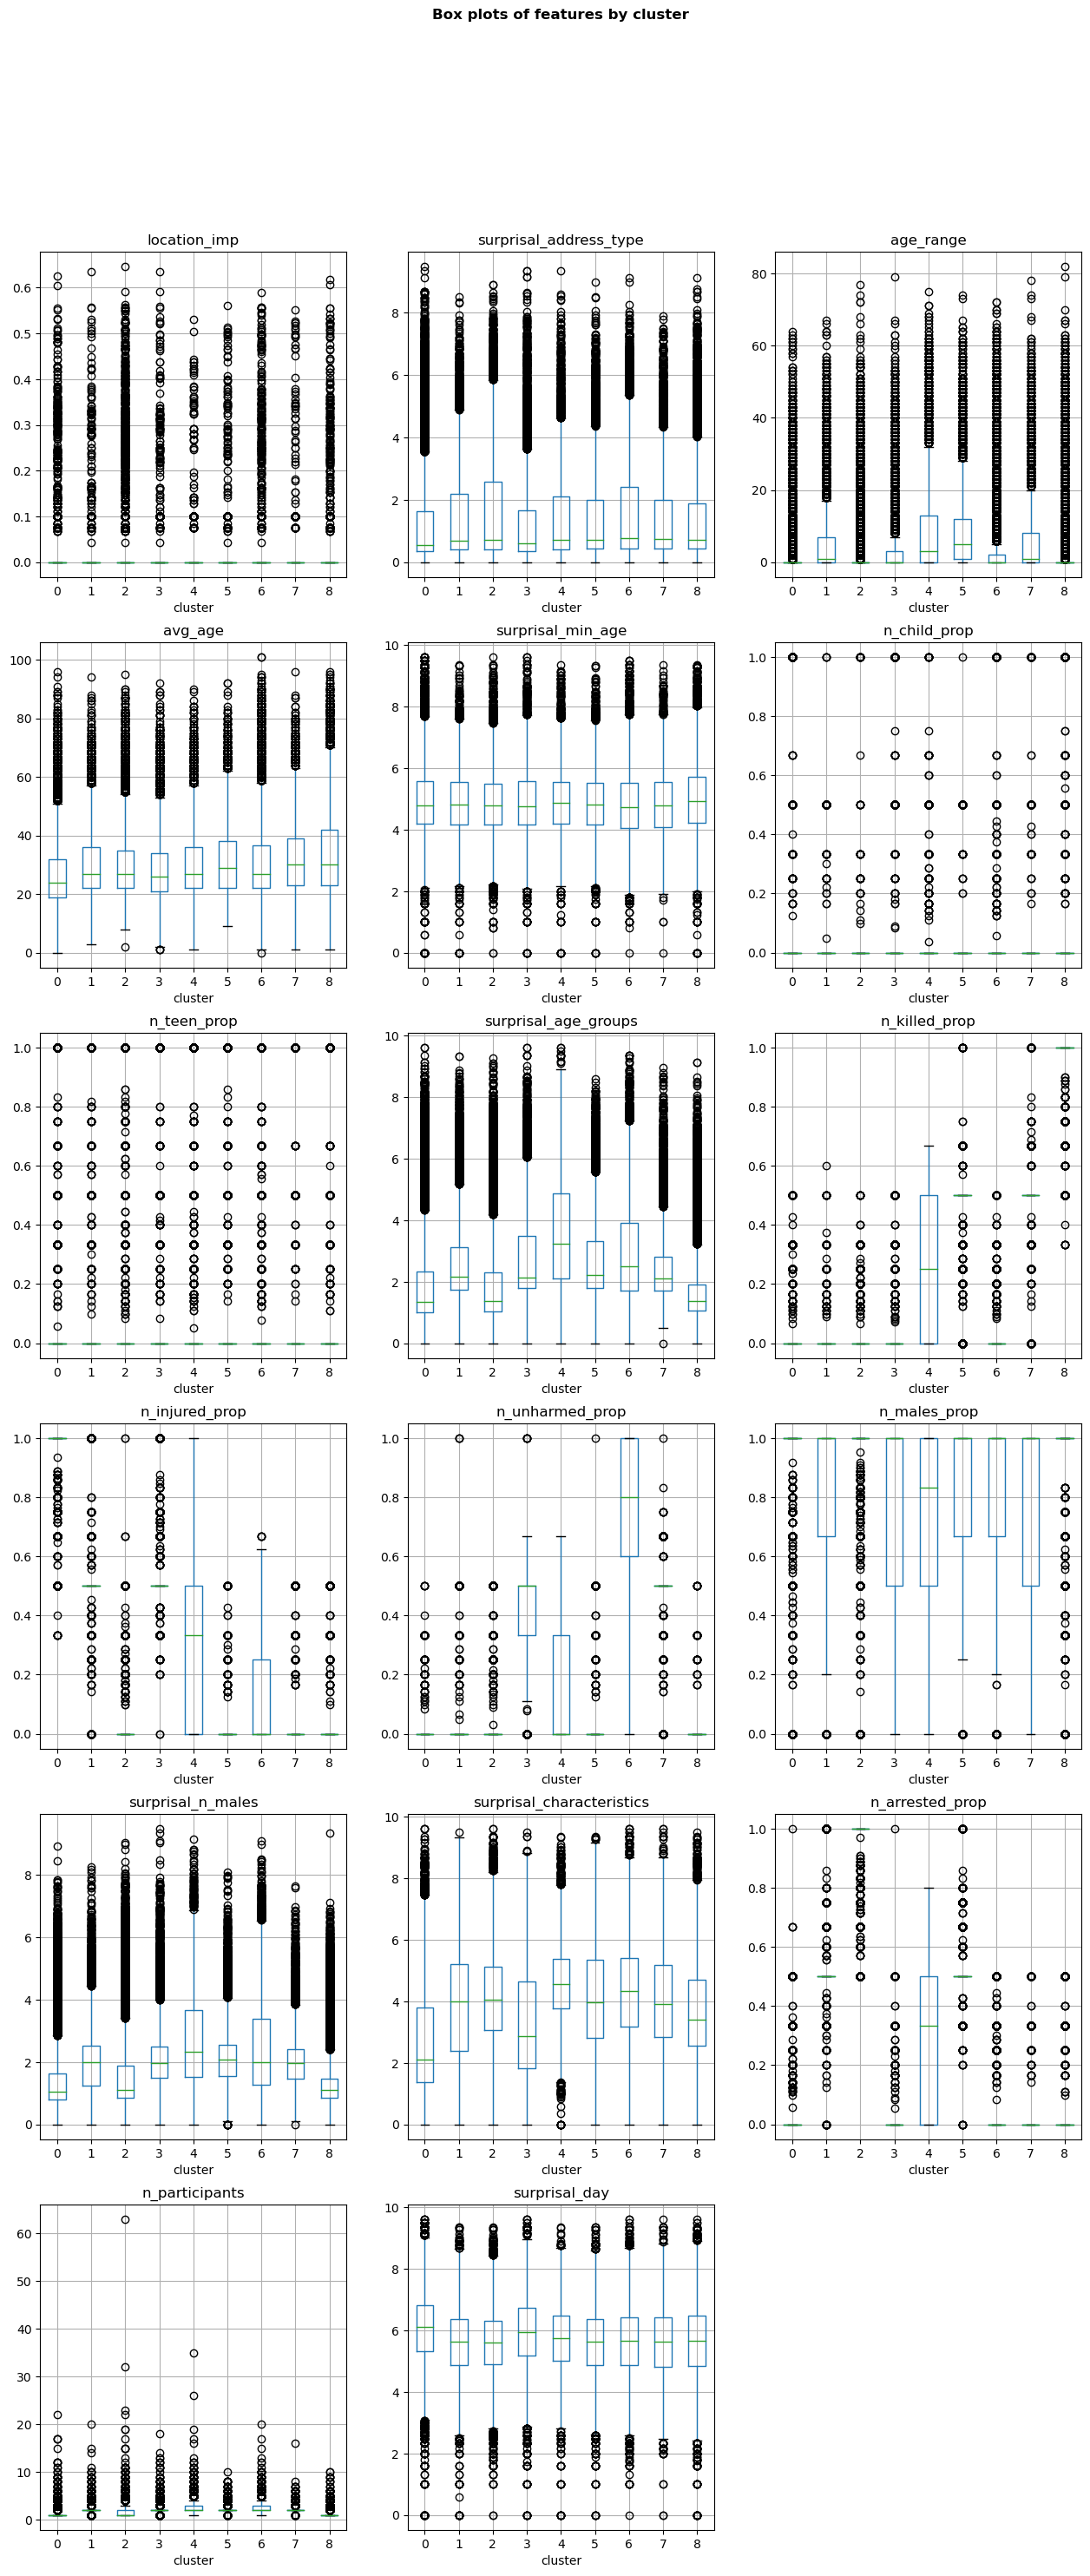

In [16]:
plot_boxes_by_cluster(
    df=incidents_df,
    features=features_to_cluster,
    cluster_column='cluster',
    figsize=(15, 35),
    title='Box plots of features by cluster'
)

The distributions of the variables are in line with the observations made looking at the average values of the features in the clusters.

## Evaluation of the clustering results

## Internal indices

In [17]:
clustering_scores = {}
se_per_point = compute_se_per_point(X=X, clusters=clusters, centroids=prototypes)
clustering_scores['SSE'] = se_per_point.sum()
clustering_scores['BSS'] = compute_bss_per_cluster(X=X, clusters=incidents_df['cluster'], centroids=prototypes, weighted=True).sum()
clustering_scores['davies_bouldin_score'] = davies_bouldin_score(X=X, labels=incidents_df['cluster'])
clustering_scores['calinski_harabasz_score'] = calinski_harabasz_score(X=X, labels=incidents_df['cluster'])
clustering_scores['silhouette_score'] = silhouette_score(X=X, labels=incidents_df['cluster'])
pd.DataFrame(clustering_scores, index=['SOM'])

,SSE,BSS,davies_bouldin_score,calinski_harabasz_score,silhouette_score
SOM,49286.358623,44254.573752,2.0395,26023.717732,0.243712


We plot the sihlouette for each point:

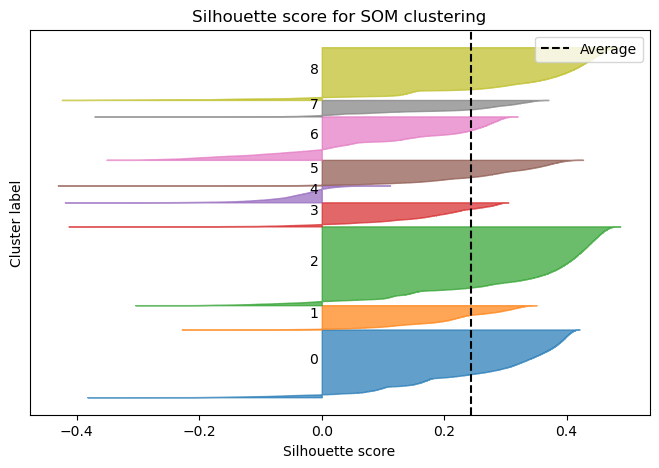

In [18]:
fig, axs = plt.subplots(1, figsize=(8,5))
silhouette_per_point = silhouette_samples(X=X, labels=incidents_df['cluster'])
plot_scores_per_point(
    score_per_point=silhouette_per_point,
    clusters=incidents_df['cluster'],
    score_name='Silhouette score', ax=axs,
    title=f'Silhouette score for SOM clustering',
    color_palette=sns.color_palette('tab10'),
    minx=-0.02
)

The majority of points in cluster 4 have a negative silhouette score.

We visualize SSE for each feature:

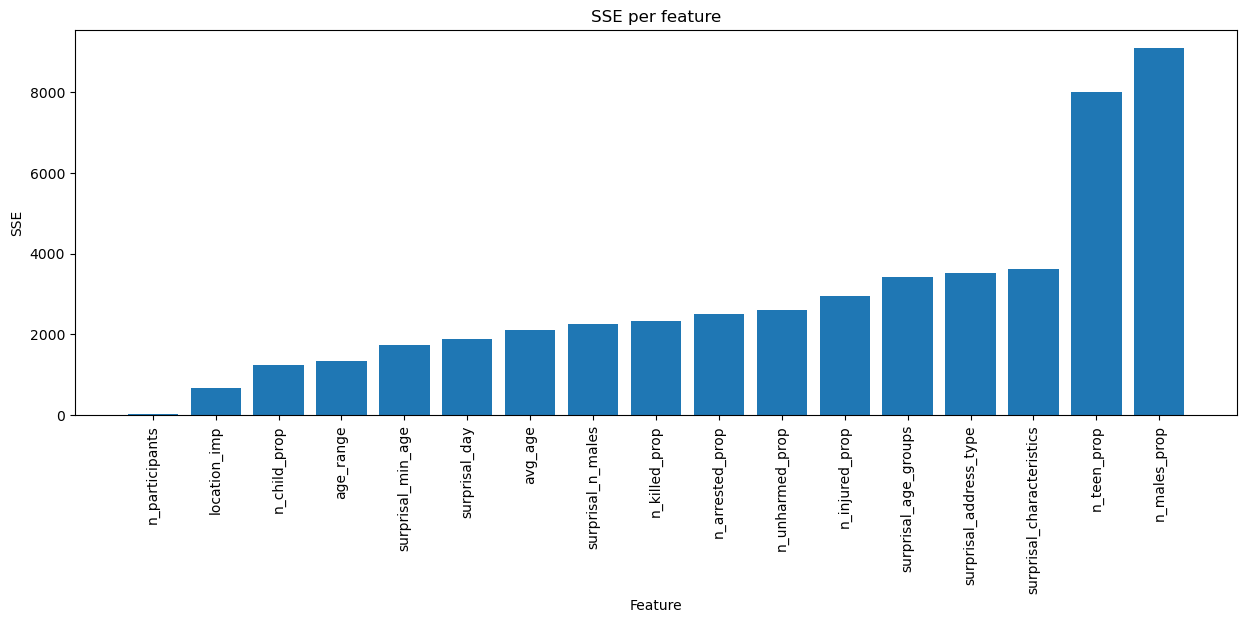

In [19]:
sse_feature = []
for i in range(X.shape[1]):
    sse_feature.append(compute_se_per_point(X=X[:,i], clusters=clusters, centroids=prototypes[:,i]).sum())

plt.figure(figsize=(15, 5))
sse_feature_sorted, clustering_features_sorted = zip(*sorted(zip(sse_feature, features_to_cluster)))
plt.bar(range(len(sse_feature_sorted)), sse_feature_sorted)
plt.xticks(range(len(sse_feature_sorted)), clustering_features_sorted)
plt.xticks(rotation=90)
plt.ylabel('SSE')
plt.xlabel('Feature')
plt.title('SSE per feature');

As in K-means, the features that contribute the most to the SSE are n_males_prop and n_teen_prop.

We visualize SSE for each point:

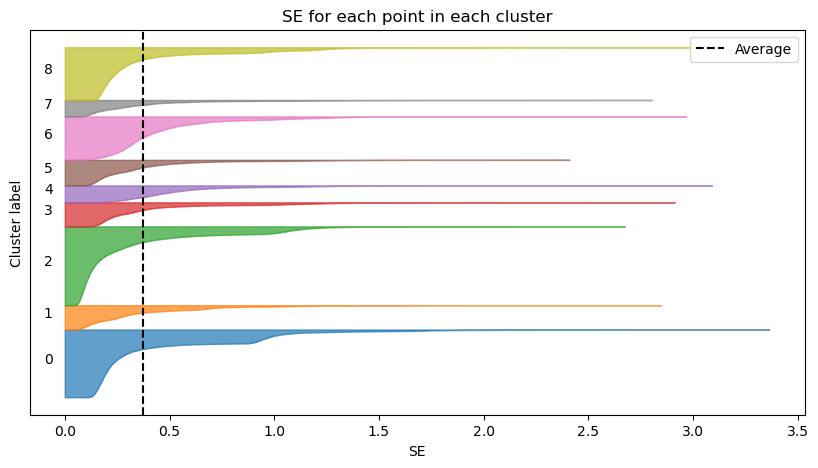

In [20]:
se_per_point = compute_se_per_point(X=X, clusters=clusters, centroids=prototypes)
fig, axs = plt.subplots(1, figsize=(10,5))
plot_scores_per_point(
    score_per_point=se_per_point,
    clusters=clusters,
    score_name='SE',
    ax=axs,
    color_palette=sns.color_palette('tab10'),
    minx=-0.1
)

We now compute cohesion (SSE) and separation (BSS) for each cluster and visualize it:

Text(0.5, 0.98, 'Cohesion and separation measures for each cluster')

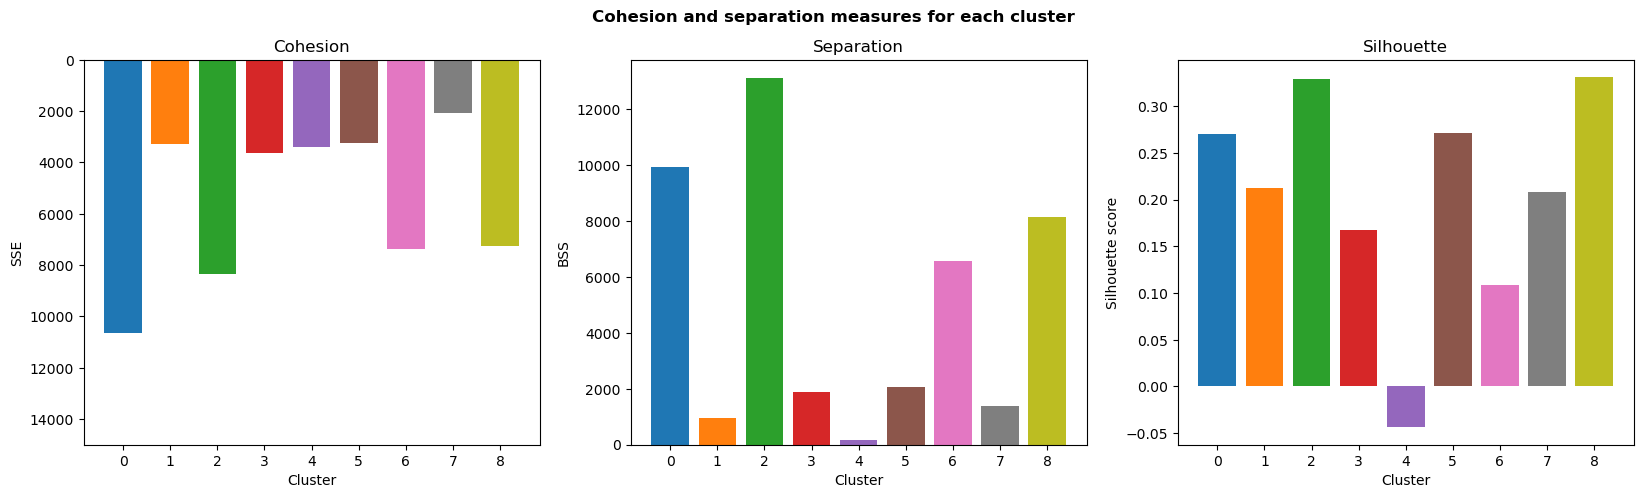

In [21]:
# compute cohesion for each cluster
se_per_cluster = np.zeros(n_clusters)
sizes = np.ones(prototypes.shape[0])
for i in range(n_clusters):
    se_per_cluster[i] = np.sum(se_per_point[np.where(clusters == i)[0]])/sizes[i]
# compute separation for each cluster
bss_per_cluster = compute_bss_per_cluster(X, clusters, prototypes, weighted=True)
# compute average silhouette score for each cluster
silhouette_per_cluster = np.zeros(n_clusters)
for i in range(n_clusters):
    silhouette_per_cluster[i] = silhouette_per_point[np.where(clusters == i)[0]].mean()
# visualize the result
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
axs[0].bar(range(n_clusters), se_per_cluster, color=sns.color_palette('tab10'))
axs[0].set_ylim(15000, 0)
axs[0].set_title('Cohesion')
axs[0].set_ylabel('SSE')
axs[1].bar(range(n_clusters), bss_per_cluster, color=sns.color_palette('tab10'))
axs[1].set_title('Separation')
axs[1].set_ylabel('BSS')
axs[2].bar(range(n_clusters), silhouette_per_cluster, color=sns.color_palette('tab10'))
axs[2].set_title('Silhouette')
axs[2].set_ylabel('Silhouette score')

for i in range(3):
    axs[i].set_xlabel('Cluster')
    axs[i].set_xticks(range(n_clusters))
    axs[i].set_xticklabels(range(n_clusters))

plt.suptitle('Cohesion and separation measures for each cluster', fontweight='bold')

We visualize the distance matrix sorted by cluster computed on a stratified subsample of 5000 points:

(array([[0.        , 1.10039398, 1.1762431 , ..., 1.81689478, 1.79619338,
         1.78978459],
        [1.10039398, 0.        , 0.64666279, ..., 1.43830526, 1.43142869,
         1.43029701],
        [1.1762431 , 0.64666279, 0.        , ..., 1.50572631, 1.52765781,
         1.49538414],
        ...,
        [1.81689478, 1.43830526, 1.50572631, ..., 0.        , 0.31410303,
         0.11956538],
        [1.79619338, 1.43142869, 1.52765781, ..., 0.31410303, 0.        ,
         0.27302561],
        [1.78978459, 1.43029701, 1.49538414, ..., 0.11956538, 0.27302561,
         0.        ]]),
 array([[0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]]))

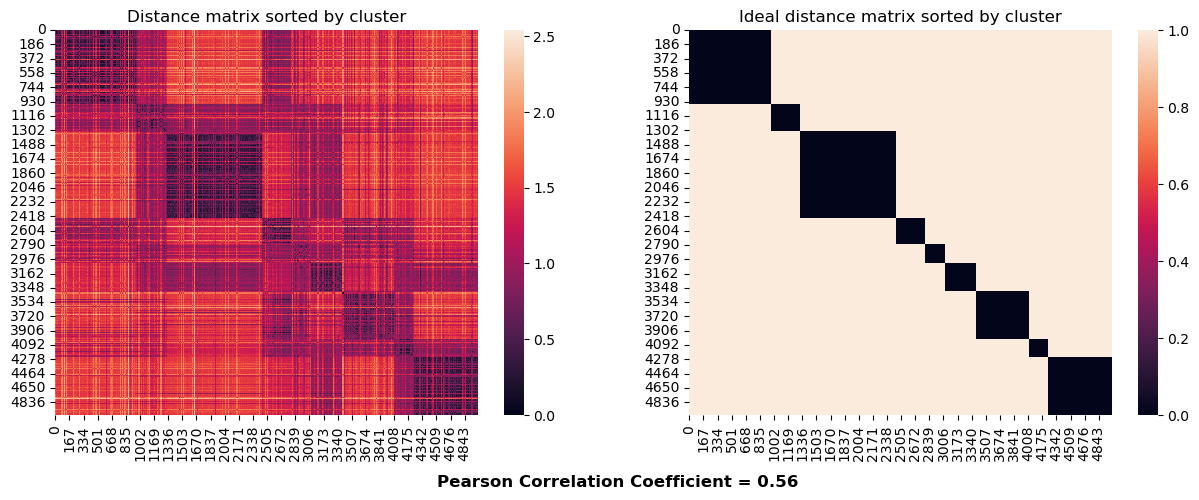

In [22]:
clusters = incidents_df['cluster'].to_numpy()
plot_distance_matrices(X, n_samples=5000, clusters=clusters)

The matrix is not so crisp as the one obtained with K-means, but we can still see some patterns.

## External indices

We measure the extent to which the discovered clustering structure matches some categorical features of the dataset:

In [23]:
incidents_df['unharmed'] = incidents_df['n_unharmed'] > 0
incidents_df['arrested'] = incidents_df['n_arrested'] > 0
incidents_df['males'] = incidents_df['n_males'] > 0
incidents_df['females'] = incidents_df['n_females'] > 0
external_score_df = compute_permutation_invariant_external_metrics(
    incidents_df,
    'cluster',
    ['shots', 'aggression', 'suicide', 'injuries', 'death', 'drugs', 'illegal_holding', 'unharmed', 'arrested', 'males', 'females']
)
external_score_df

,adjusted rand score,normalized mutual information,homogeneity,completeness
feature,,,,
shots,0.069359,0.197845,0.472705,0.125102
aggression,0.135028,0.214819,0.427773,0.143421
suicide,0.002171,0.038604,0.333547,0.020487
injuries,0.230996,0.365046,0.731321,0.243228
death,0.200991,0.358430,0.764063,0.234132
drugs,-0.005876,0.050790,0.210976,0.028870
illegal_holding,0.002219,0.039044,0.138046,0.022738
unharmed,0.168317,0.335109,0.771424,0.214046
arrested,0.250825,0.402127,0.804247,0.268086


In [26]:
write_clusters_to_csv(clusters, f'../data/clustering_labels/SOM_clusters.csv')
pd.DataFrame(clustering_scores, index=['SOM']).to_csv(f'../data/clustering_labels/SOM_internal_scores.csv')
external_score_df.to_csv(f'../data/clustering_labels/SOM_external_scores.csv')